<a href="https://colab.research.google.com/github/itsarshan/DiaPredictorX-Intelligence-for-Prevention/blob/main/DiaPredictorX_Intelligence_for_Prevention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve, brier_score_loss
)
from sklearn.inspection import permutation_importance
from joblib import Memory

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



Load Data

In [2]:
# Ensure 'diabetes.csv' (attached Pima dataset) is in the working directory
df = pd.read_csv("diabetes.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Quick Cleaning

In [3]:

df_clean = df.copy()

cols_with_invalid_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df_clean[cols_with_invalid_zero] = df_clean[cols_with_invalid_zero].replace(0, np.nan)


features = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"
]
X = df_clean[features]
y = df_clean["Outcome"].astype(int)

#Perform a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Training data shape:", X_train.shape)
print("Testing data shape: ", X_test.shape)


Training data shape: (614, 8)
Testing data shape:  (154, 8)


In [ ]:
# Numeric transformer for LR
num_tf_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Numeric transformer for Trees
num_tf_no_scale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# ColumnTransformers (all features are numeric)
pre_lr = ColumnTransformer(
    transformers=[("num", num_tf_scaled, num_cols)],
    remainder="drop"
)
pre_tree = ColumnTransformer(
    transformers=[("num", num_tf_no_scale, num_cols)],
    remainder="drop"
)




Model Pipelines and Grids

In [ ]:
# Logistic Regression
lr_pipe = Pipeline(steps=[
    ("pre", pre_lr),
    ("clf", LogisticRegression(
        max_iter=2000, class_weight="balanced", solver="liblinear", C=1.0, penalty="l2"
    ))
], memory=memory)

# Random Forest
rf_pipe = Pipeline(steps=[
    ("pre", pre_tree),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
], memory=memory)

# Gradient Boosting
gb_pipe = Pipeline(steps=[
    ("pre", pre_tree),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
], memory=memory)


GridSearchCV Training

In [ ]:
def fit_search_fast_grid(pipe, grid, name, use_subsample=True, n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    if use_subsample:
        X_sub, _, y_sub, _ = train_test_split(
            X_train, y_train, train_size=0.6, stratify=y_train, random_state=RANDOM_STATE
        )
        gs.fit(X_sub, y_sub)
    else:
        gs.fit(X_train, y_train)
    print(f"\n{name} (fast grid) best params:", gs.best_params_)
    best_est = gs.best_estimator_
    best_est.fit(X_train, y_train)  # refit on full train
    return best_est

def fit_search_fast_random(pipe, distributions, name, n_iter=12, use_subsample=True, n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=distributions,
        n_iter=n_iter,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    if use_subsample:
        X_sub, _, y_sub, _ = train_test_split(
            X_train, y_train, train_size=0.6, stratify=y_train, random_state=RANDOM_STATE
        )
        rs.fit(X_sub, y_sub)
    else:
        rs.fit(X_train, y_train)
    print(f"\n{name} (fast random) best params:", rs.best_params_)
    best_est = rs.best_estimator_
    best_est.fit(X_train, y_train)  # refit on full train
    return best_est


Minimal-Fast Search Spaces

In [ ]:
# Logistic Regression: fast baseline (no grid to save time)
best_lr = lr_pipe.fit(X_train, y_train)

# Random Forest: small fast grid (or switch to randomized below if preferred)
rf_grid_fast = {
    "clf__n_estimators": [200, 300],
    "clf__max_depth": [None, 10],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt"]
}
best_rf = fit_search_fast_grid(rf_pipe, rf_grid_fast, "Random Forest", use_subsample=True, n_splits=3)

# Gradient Boosting: small fast grid
gb_grid_fast = {
    "clf__n_estimators": [200, 300],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3]
}
best_gb = fit_search_fast_grid(gb_pipe, gb_grid_fast, "Gradient Boosting", use_subsample=True, n_splits=3)



Fitting 3 folds for each of 8 candidates, totalling 24 fits

Random Forest (fast grid) best params: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Gradient Boosting (fast grid) best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200}


Evaluation (Accuracy, ROC-AUC, PR-AUC, Plots)


Logistic Regression (baseline) — Test accuracy: 0.7338, ROC-AUC: 0.8126, PR-AUC: 0.6727

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



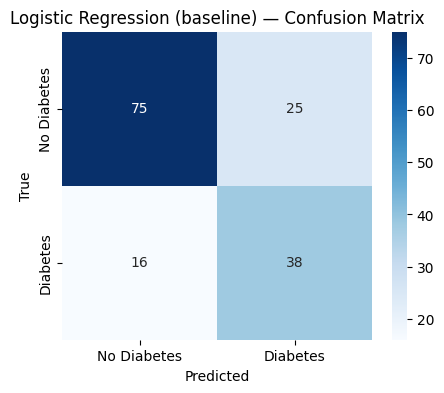

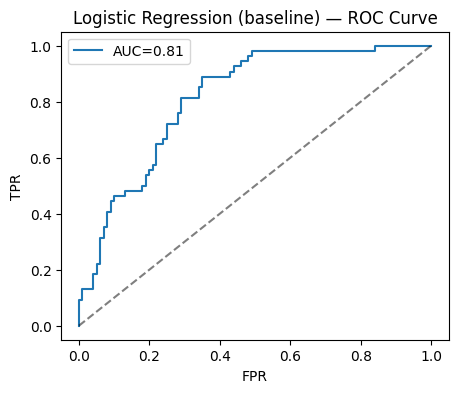

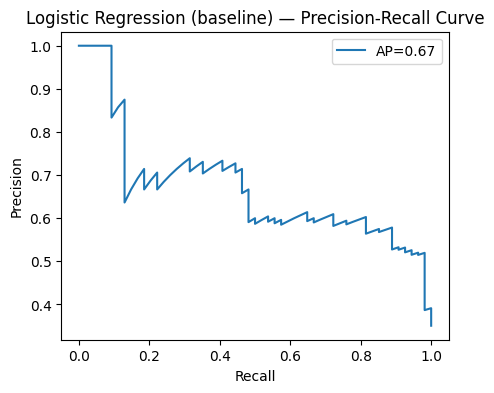


Random Forest (fast search) — Test accuracy: 0.7727, ROC-AUC: 0.8291, PR-AUC: 0.7136

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       100
           1       0.68      0.67      0.67        54

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



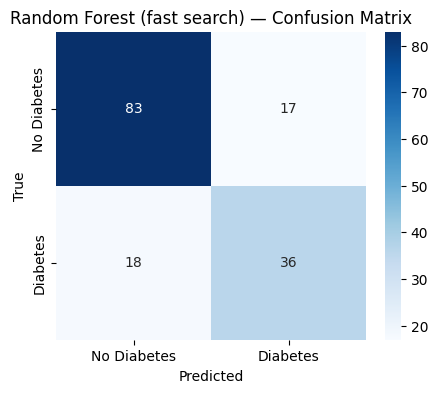

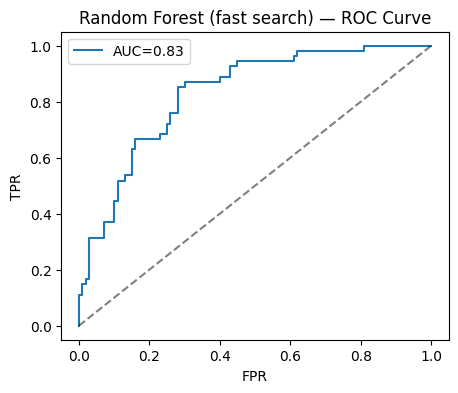

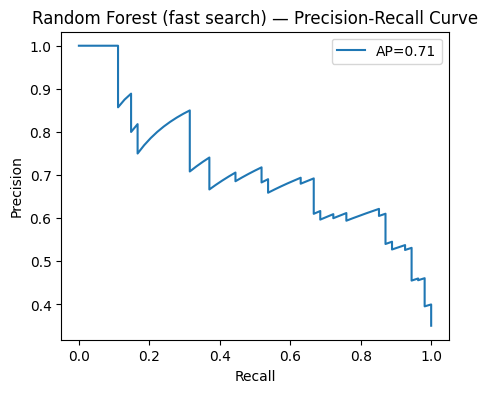


Gradient Boosting (fast search) — Test accuracy: 0.7662, ROC-AUC: 0.8298, PR-AUC: 0.7179

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83       100
           1       0.69      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



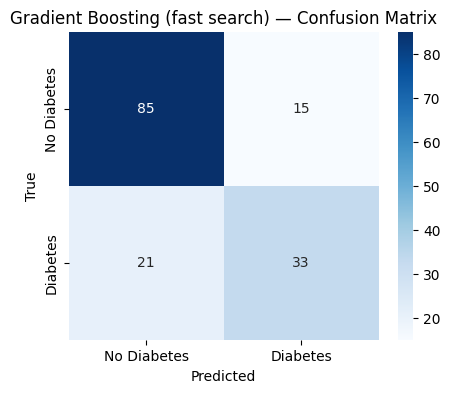

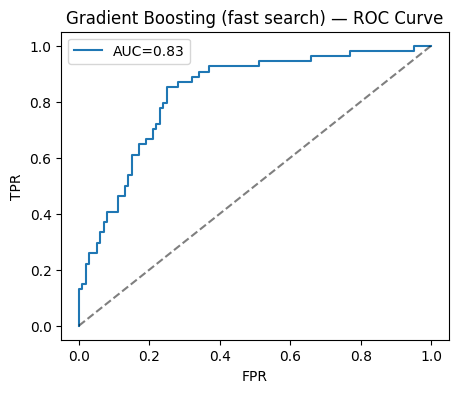

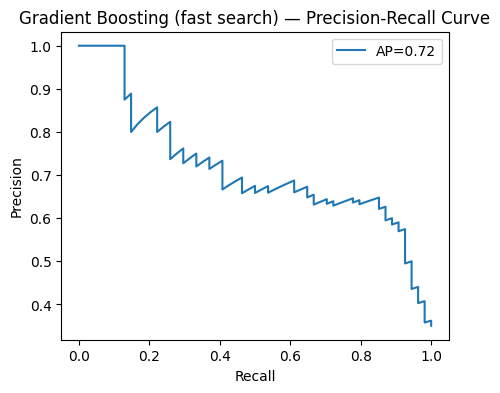


Summary (sorted by ROC-AUC):
                              name  accuracy   roc_auc    pr_auc
2  Gradient Boosting (fast search)  0.766234  0.829815  0.717928
1      Random Forest (fast search)  0.772727  0.829074  0.713623
0   Logistic Regression (baseline)  0.733766  0.812593  0.672659


In [ ]:
def report_all(name, est):
    y_pred = est.predict(X_test)
    if hasattr(est, "predict_proba"):
        y_proba = est.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred.astype(float)

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    ap  = average_precision_score(y_test, y_proba)

    print(f"\n{name} — Test accuracy: {acc:.4f}, ROC-AUC: {roc:.4f}, PR-AUC: {ap:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Diabetes", "Diabetes"],
                yticklabels=["No Diabetes", "Diabetes"])
    plt.title(f"{name} — Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precisions, recalls, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc:.2f}")
    plt.plot([0,1],[0,1],"k--", alpha=0.5)
    plt.title(f"{name} — ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(recalls, precisions, label=f"AP={ap:.2f}")
    plt.title(f"{name} — Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    return {"name": name, "accuracy": acc, "roc_auc": roc, "pr_auc": ap}

scores = []
scores.append(report_all("Logistic Regression (baseline)", best_lr))
scores.append(report_all("Random Forest (fast search)", best_rf))
scores.append(report_all("Gradient Boosting (fast search)", best_gb))

print("\nSummary (sorted by ROC-AUC):")
print(pd.DataFrame(scores).sort_values(by="roc_auc", ascending=False))


Calibrate Probabilities (for reliable risk percentages)

In [ ]:
# Pick the best performing model from the summary (often RF or GB)
base_model = best_rf  # change to best_gb or best_lr if desired

# Calibrate using Platt scaling (sigmoid) with 3-fold CV on training data
calibrated_model = CalibratedClassifierCV(base_model, method="sigmoid", cv=3)
calibrated_model.fit(X_train, y_train)

# Quick calibration check
y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]
print("Calibrated Brier score:", round(brier_score_loss(y_test, y_proba_cal), 4))
print("Calibrated ROC-AUC:", round(roc_auc_score(y_test, y_proba_cal), 4))


Calibrated Brier score: 0.1619
Calibrated ROC-AUC: 0.8272


Calibrate Probabilities (for reliable risk percentages)

In [ ]:
# Pick the best performing model from the summary (often RF or GB)
base_model = best_rf  # change to best_gb or best_lr if desired

# Calibrate using Platt scaling (sigmoid) with 3-fold CV on training data
calibrated_model = CalibratedClassifierCV(base_model, method="sigmoid", cv=3)
calibrated_model.fit(X_train, y_train)

# Quick calibration check
y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]
print("Calibrated Brier score:", round(brier_score_loss(y_test, y_proba_cal), 4))
print("Calibrated ROC-AUC:", round(roc_auc_score(y_test, y_proba_cal), 4))


Calibrated Brier score: 0.1619
Calibrated ROC-AUC: 0.8272


Unique Risk Advisory (≥80% => High Risk + Prevention Tips)

In [ ]:
def risk_tier_and_advice(prob_diabetes: float):
    """
    Tiers:
      - High Risk: >=0.80
      - Moderate Risk: 0.50–0.79
      - Low Risk: <0.50
    """
    if prob_diabetes >= 0.80:
        tier = "High Risk"
        advice = [
            "Schedule a clinical evaluation soon (fasting glucose and/or HbA1c).",
            "Start lifestyle changes now: reduce refined carbs/sugary drinks; focus on fiber-rich foods, lean proteins, and portion control.",
            "Aim for ≥150 minutes/week of moderate activity plus 2 days/week resistance training.",
            "If overweight, target 5–7% weight reduction in 3–6 months.",
            "Track blood pressure and BMI; set personalized targets with a clinician."
        ]
    elif prob_diabetes >= 0.50:
        tier = "Moderate Risk"
        advice = [
            "Adopt a balanced meal plan and reduce added sugars.",
            "Increase physical activity toward ≥150 minutes/week.",
            "Monitor weight and waist circumference routinely.",
            "Consider home BP checks if feasible."
        ]
    else:
        tier = "Low Risk"
        advice = [
            "Maintain balanced diet and regular exercise.",
            "Keep routine check-ups; re-screen if symptoms or risks change.",
            "Prioritize sleep (7–9 hours) and stress management."
        ]
    return tier, advice


Inference Helper (returns label, calibrated probability, tier, advice)

In [ ]:
def build_predict_fn(pipeline):
    def predict_one(
        Pregnancies: float,
        Glucose: float,
        BloodPressure: float,
        SkinThickness: float,
        Insulin: float,
        BMI: float,
        DiabetesPedigreeFunction: float,
        Age: float,
        positive_threshold: float = 0.50
    ):
        inp = pd.DataFrame([{
            "Pregnancies": Pregnancies,
            "Glucose": Glucose,
            "BloodPressure": BloodPressure,
            "SkinThickness": SkinThickness,
            "Insulin": Insulin,
            "BMI": BMI,
            "DiabetesPedigreeFunction": DiabetesPedigreeFunction,
            "Age": Age
        }])
        proba = pipeline.predict_proba(inp)[0, 1]
        pred = int(proba >= positive_threshold)
        tier, advice = risk_tier_and_advice(proba)
        return {
            "prediction_label": "Diabetes" if pred == 1 else "No Diabetes",
            "prob_diabetes": round(float(proba), 4),
            "prob_no_diabetes": round(float(1 - proba), 4),
            "risk_tier": tier,
            "advice": advice
        }
    return predict_one

final_model = calibrated_model
predict_fn = build_predict_fn(final_model)

# Example
example = predict_fn(
    Pregnancies=2, Glucose=140, BloodPressure=70, SkinThickness=20,
    Insulin=90, BMI=30.5, DiabetesPedigreeFunction=0.5, Age=35
)
example


{'prediction_label': 'No Diabetes',
 'prob_diabetes': 0.4708,
 'prob_no_diabetes': 0.5292,
 'risk_tier': 'Low Risk',
 'advice': ['Maintain balanced diet and regular exercise.',
  'Keep routine check-ups; re-screen if symptoms or risks change.',
  'Prioritize sleep (7–9 hours) and stress management.']}

Batch Scoring + High-Risk Flag (>=80%)

In [ ]:
def score_dataframe(pipeline, X_df: pd.DataFrame, threshold: float = 0.50):
    proba = pipeline.predict_proba(X_df)[:, 1]
    pred = (proba >= threshold).astype(int)
    out = X_df.copy()
    out["prob_diabetes"] = proba
    out["pred"] = pred
    tiers, advs = [], []
    for p in proba:
        t, a = risk_tier_and_advice(p)
        tiers.append(t)
        advs.append("; ".join(a))
    out["risk_tier"] = tiers
    out["advice"] = advs
    return out

report_test = score_dataframe(final_model, X_test, threshold=0.50)
high_risk = report_test[report_test["prob_diabetes"] >= 0.80].sort_values("prob_diabetes", ascending=False)
print("High-risk (>=80%) count:", len(high_risk))
high_risk.head(10)


High-risk (>=80%) count: 8


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,prob_diabetes,pred,risk_tier,advice
235,4,171.0,72.0,NaN,NaN,43.6,0.479,26,0.853832,1,High Risk,Schedule a clinical evaluation soon (fasting g...
185,7,194.0,68.0,28.0,NaN,35.9,0.745,41,0.837116,1,High Risk,Schedule a clinical evaluation soon (fasting g...
300,0,167.0,NaN,NaN,NaN,32.3,0.839,30,0.834241,1,High Risk,Schedule a clinical evaluation soon (fasting g...
355,9,165.0,88.0,NaN,NaN,30.4,0.302,49,0.824447,1,High Risk,Schedule a clinical evaluation soon (fasting g...
332,1,180.0,NaN,NaN,NaN,43.3,0.282,41,0.815286,1,High Risk,Schedule a clinical evaluation soon (fasting g...
425,4,184.0,78.0,39.0,277.0,37.0,0.264,31,0.813885,1,High Risk,Schedule a clinical evaluation soon (fasting g...
238,9,164.0,84.0,21.0,NaN,30.8,0.831,32,0.808009,1,High Risk,Schedule a clinical evaluation soon (fasting g...
335,0,165.0,76.0,43.0,255.0,47.9,0.259,26,0.801649,1,High Risk,Schedule a clinical evaluation soon (fasting g...


 Optional: Save High-Risk Cases

In [ ]:
high_risk.to_csv("high_risk_cases.csv", index=False)
print("Saved high-risk cases to high_risk_cases.csv")


Saved high-risk cases to high_risk_cases.csv


Feature Importance (Random Forest)



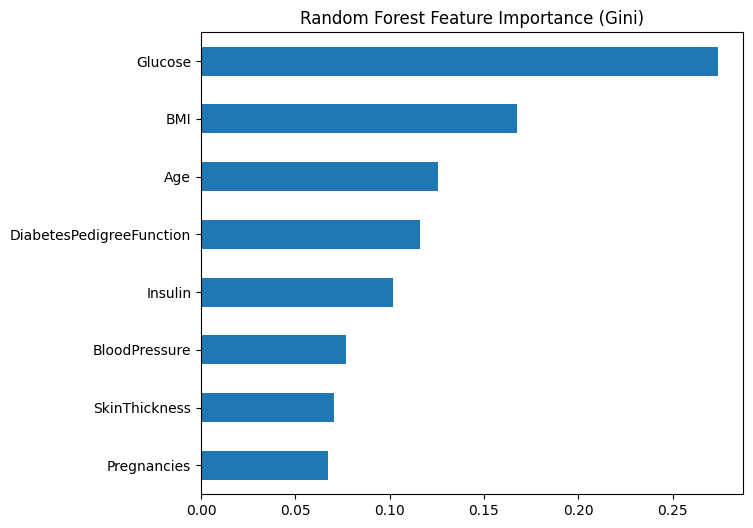

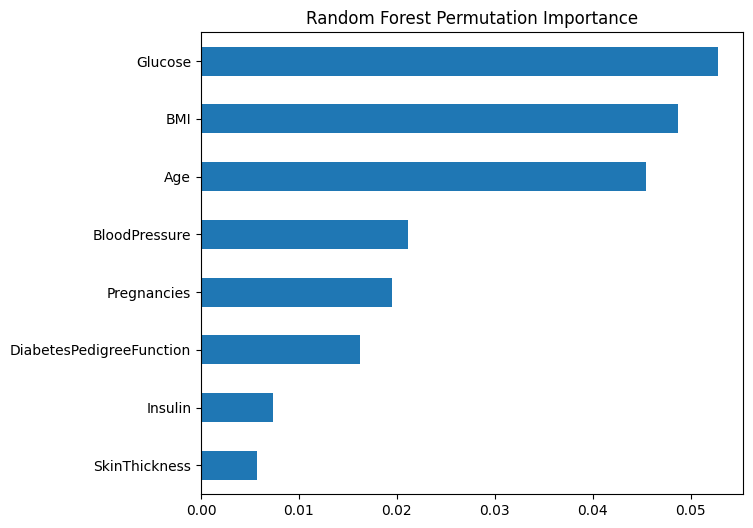

In [ ]:
# Only if the final base model is RF; skip otherwise or adapt
try:
    rf_clf = best_rf.named_steps["clf"]
    final_feature_names = num_cols

    # Native importance
    importances = pd.Series(rf_clf.feature_importances_, index=final_feature_names).sort_values(ascending=True)
    plt.figure(figsize=(7,6))
    importances.tail(15).plot(kind="barh")
    plt.title("Random Forest Feature Importance (Gini)")
    plt.show()

    # Permutation importance (reduce n_repeats if too slow)
    perm = permutation_importance(best_rf, X_test, y_test, n_repeats=8, random_state=RANDOM_STATE, n_jobs=-1)
    perm_imp = pd.Series(perm.importances_mean, index=final_feature_names).sort_values(ascending=True)
    plt.figure(figsize=(7,6))
    perm_imp.tail(15).plot(kind="barh")
    plt.title("Random Forest Permutation Importance")
    plt.show()
except Exception as e:
    print("Feature importance skipped:", e)
